In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers import TextClassificationPipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## Import Data

In [2]:
# Import train and test data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Separate train labels and text
train_labels = train['category']
train_text = train['text']
train_labels_list = train_labels.tolist()

# Separate test labels and text
test_labels = test['category']
test_text = test['text']
test_labels_list = test_labels.tolist()

## Load in Model

In [3]:
# Load in the model
model_id = 'philschmid/BERT-Banking77'
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)
classifier = pipeline('text-classification', tokenizer=tokenizer, model=model, return_all_scores=True)

/Users/wally/anaconda3/envs/amex/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


## Separate out the Errors

In [4]:
# Create a list of all the outputs from the classifier
outputs = []
for text in test_text:
    outputs.append(classifier(text))

In [5]:
output_table = []

# Iterate over each output and its corresponding index
for x, output in enumerate(outputs):
    data = output[0]
    
    # Find the maximum score and its corresponding label
    max_score_data = max(data, key=lambda d: d['score'])
    max_score = max_score_data['score']
    max_label = max_score_data['label']
    
    # Check if the predicted label is incorrect
    if max_label != test_labels_list[x]:
        output_table.append({
            'test_text': test_text[x],
            'true_label': test_labels_list[x],
            'predicted_label': max_label,
            'max_score': max_score,
            'correct': 0
        })
    
    # Check if the predicted label is correct
    if max_label == test_labels_list[x]:
        output_table.append({
            'test_text': test_text[x],
            'true_label': test_labels_list[x],
            'predicted_label': max_label,
            'max_score': max_score,
            'correct': 1
        })

output_table = pd.DataFrame(output_table)
output_table.to_csv('data/correct_or_not.csv', index=False)
output_table

,test_text,true_label,predicted_label,max_score,correct
0,How do I locate my card?,card_arrival,card_arrival,0.466481,1
1,"I still have not received my new card, I order...",card_arrival,card_arrival,0.977467,1
2,I ordered a card but it has not arrived. Help ...,card_arrival,card_arrival,0.925290,1
3,Is there a way to know when my card will arrive?,card_arrival,card_delivery_estimate,0.944849,0
4,My card has not arrived yet.,card_arrival,card_arrival,0.980883,1
...,...,...,...,...,...
3075,"If i'm not in the UK, can I still get a card?",country_support,country_support,0.974657,1
3076,How many countries do you support?,country_support,country_support,0.974706,1
3077,What countries do you do business in?,country_support,country_support,0.974942,1
3078,What are the countries you operate in.,country_support,country_support,0.973756,1


#### Create Dataframe with all Errors

In [6]:
# Visualize errors in data frame
pd.set_option('display.max_rows', 100)

errors_df = output_table[output_table['correct'] == 0]
errors_df

,test_text,true_label,predicted_label,max_score,correct
3,Is there a way to know when my card will arrive?,card_arrival,card_delivery_estimate,0.944849,0
5,When will I get my card?,card_arrival,card_delivery_estimate,0.967209,0
11,How long does a card delivery take?,card_arrival,card_delivery_estimate,0.967351,0
21,Status of the card I ordered.,card_arrival,lost_or_stolen_card,0.374375,0
32,How do I know when my card will arrive?,card_arrival,card_delivery_estimate,0.965850,0
...,...,...,...,...,...
2939,"I will need to get a new card soon, how do I o...",card_about_to_expire,order_physical_card,0.483773,0
3003,How can I verify my indentity?,verify_my_identity,why_verify_identity,0.728951,0
3012,I need to verify my identity,verify_my_identity,why_verify_identity,0.723252,0
3024,do the details of my profile have to match my ...,verify_my_identity,why_verify_identity,0.581934,0


In [7]:
# Print accuracy on test data
print(1-(len(errors_df)/len(test_labels_list)))

0.9275974025974026


#### Create Dataframe showing only errors which the model does not predict in the top 3 labels

In [8]:
# Does the model output have the correct label in the top 3 predicted labels?
not_top3_errors = []

# Iterate over each output
for x, output in enumerate(outputs):
    data = output[0]
    
    # Sort data in descending order
    sorted_data = sorted(data, key=lambda x: x['score'], reverse=True)

    # Extract the top 3 labels and scores
    top_3_labels = [d['label'] for d in sorted_data[:3]]
    top_3_scores = [d['score'] for d in sorted_data[:3]]

    # Check if the true label is in the top 3 predicted labels
    if test_labels_list[x] not in top_3_labels:
        not_top3_errors.append({
            'test_text': test_text[x],
            'true_label': test_labels_list[x],
            'predicted_labels': top_3_labels,
            'max_scores': top_3_scores
        })

# Convert output to dataframe and output
not_top3_errors_df = pd.DataFrame(not_top3_errors)
not_top3_errors_df

,test_text,true_label,predicted_labels,max_scores
0,Status of the card I ordered.,card_arrival,"[lost_or_stolen_card, order_physical_card, vis...","[0.3743751347064972, 0.20955437421798706, 0.11..."
1,Why am I being charged more ?,card_payment_wrong_exchange_rate,"[card_payment_fee_charged, transfer_fee_charge...","[0.9031341671943665, 0.029355304315686226, 0.0..."
2,"I am a new customer, and I happened to look at...",extra_charge_on_statement,"[transfer_fee_charged, card_payment_fee_charge...","[0.39594128727912903, 0.17250247299671173, 0.1..."
3,My account was charged for a withdraw I tried ...,pending_cash_withdrawal,"[declined_cash_withdrawal, cash_withdrawal_cha...","[0.9604564905166626, 0.006293033249676228, 0.0..."
4,"There is an incoming payment into my account, ...",fiat_currency_support,"[pending_card_payment, reverted_card_payment?,...","[0.9292459487915039, 0.007912235334515572, 0.0..."
5,Am I able to exchange currencies?,fiat_currency_support,"[exchange_via_app, activate_my_card, transfer_...","[0.9756021499633789, 0.001901178271509707, 0.0..."
6,"Ordered awhile back, what is the ETA in the US?",card_delivery_estimate,"[fiat_currency_support, atm_support, supported...","[0.30008670687675476, 0.14428173005580902, 0.0..."
7,Can I space out how often money is transferred...,automatic_top_up,"[balance_not_updated_after_bank_transfer, tran...","[0.28899362683296204, 0.27631181478500366, 0.1..."
8,"Is there a top-up feature, if there isn't a lo...",automatic_top_up,"[pending_top_up, top_up_limits, top_up_failed]","[0.7524844408035278, 0.1040065810084343, 0.016..."
9,How do I unblock my card using the app?,card_not_working,"[pin_blocked, top_up_by_card_charge, get_physi...","[0.9723111987113953, 0.0022404524497687817, 0...."


In [9]:
# Print accuracy on test data
print(1-(len(not_top3_errors_df)/len(test_labels_list)))

0.974025974025974


## Create Graph Showing Threshold Max Score Confidence vs. Error Rate

In [10]:
# Make predictions on test data
predictions_list = []

for output in outputs:
    data = output[0]

    # Find the maximum score and its corresponding label
    max_score_data = max(data, key=lambda d: d['score'])
    predictions_list.append(max_score_data)

test_predictions = []
for output in predictions_list:
    test_predictions.append(output)


In [11]:
# Function to calculate precision, recall, and F1 score based on threshold
def calculate_metrics(predictions, true_labels, threshold):
    predicted_labels = []
    for pred in predictions:
        if pred['score'] < threshold:
            predicted_labels.append('incorrect')
        else:
            predicted_labels.append(pred['label'])

    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=1)
    
    return precision, recall, f1

# Define thresholds to test
thresholds = np.linspace(0,0.95,150)

# # Calculate precision, recall, and F1 score for each threshold
# for threshold in thresholds:
#     precision, recall, f1 = calculate_metrics(test_predictions, test_labels_list, threshold)
#     print(f"At threshold {threshold}: Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

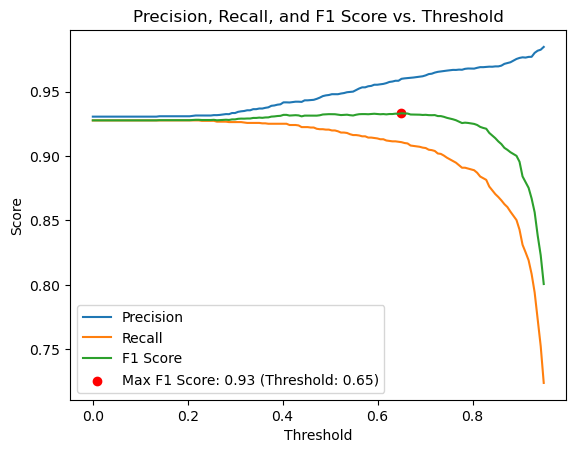

In [12]:
# Lists to store precision, recall, and F1 score for each threshold
precisions = []
recalls = []
f1_scores = []

# Calculate precision, recall, and F1 score for each threshold
for threshold in thresholds:
    precision, recall, f1 = calculate_metrics(test_predictions, test_labels_list, threshold)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Find the threshold corresponding to the maximum F1 score
max_f1_index = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_index]
max_f1_score = f1_scores[max_f1_index]

# Plot precision
plt.plot(thresholds, precisions, label='Precision')

# Plot recall
plt.plot(thresholds, recalls, label='Recall')

# Plot F1 score
plt.plot(thresholds, f1_scores, label='F1 Score')

# Highlight the maximum F1 score
plt.scatter(max_f1_threshold, max_f1_score, color='red', label=f'Max F1 Score: {max_f1_score:.2f} (Threshold: {max_f1_threshold:.2f})')

# Add labels and title
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()

# Show the plot
plt.show()

## Train A Decision Tree Model On the Results of the BERT Model to Predict if an Error will Occur

In [13]:
text = output_table['test_text']
labels = output_table['correct']

# Create a Vectorizer
vectorizer = TfidfVectorizer(use_idf=True)
X = vectorizer.fit_transform(text)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)

In [14]:
# Train random forest  classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# Predict on test set
rf_test_predictions = rf_clf.predict(X_test)
print(classification_report(y_test, rf_test_predictions))

              precision    recall  f1-score   support

           0       0.50      0.03      0.05        70
           1       0.93      1.00      0.96       854

    accuracy                           0.92       924
   macro avg       0.71      0.51      0.51       924
weighted avg       0.89      0.92      0.89       924



In [16]:
#, zero_division=1

## Extracting Logits and Softmax Probabilities

In [17]:
# Output of raw logits (from Mariya's email/stackoverflow code)
class logitFinder(TextClassificationPipeline):
    def postprocess(self, model_outputs):
        best_class = model_outputs["logits"]
        return best_class

classifier = pipeline('text-classification', model=model_id, tokenizer=tokenizer)
type(classifier)

pipe = logitFinder(model = model, tokenizer = tokenizer)
logit_outputs = pipe(test_text.tolist(), batch_size=2, truncation="only_first")

In [18]:
# Convert it into a NumPy array
logits_array = np.array([np.array(logit) for logit in logit_outputs])

# Flatten the logits array to ensure consistent shape
logits_flat = logits_array.reshape(logits_array.shape[0], -1)

# Apply softmax function to logits
softmax_probs = np.exp(logits_flat) / np.sum(np.exp(logits_flat), axis=1, keepdims=True)

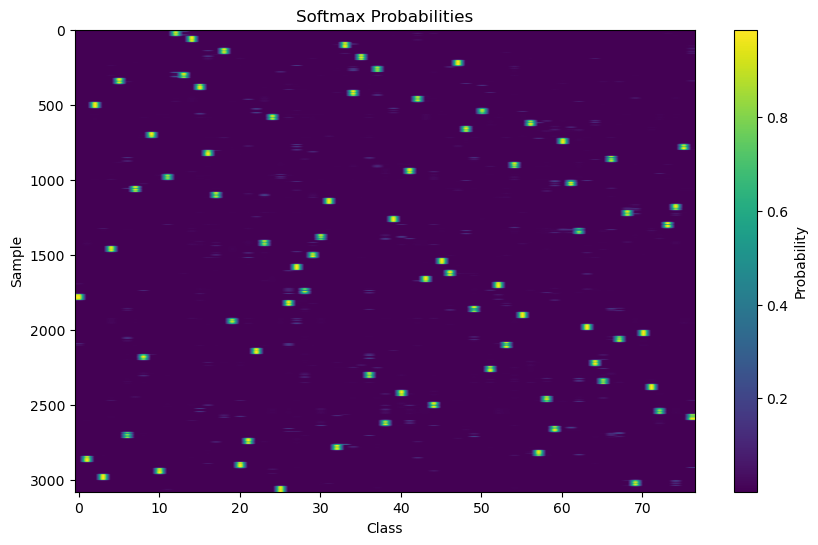

In [19]:
# Visualize Softmaxes
# Apply softmax function to logits
softmax_probs = np.exp(logits_flat) / np.sum(np.exp(logits_flat), axis=1, keepdims=True)

# Define a function to visualize softmax probabilities
def visualize_softmax_probs(softmax_probs):
    # Plotting heatmap
    plt.figure(figsize=(10, 6))
    plt.imshow(softmax_probs, cmap='viridis', aspect='auto')
    plt.colorbar(label='Probability')
    plt.xlabel('Class')
    plt.ylabel('Sample')
    plt.title('Softmax Probabilities')
    plt.show()

# Visualize softmax probabilities
visualize_softmax_probs(softmax_probs)

## Implementation of Softmax Prediction Probability from Hendrycks and Gimpel

In [20]:
# Create dataframe of correct predictions

# Elements to exclude
error_text = errors_df

# Create a boolean mask to filter out elements
mask = np.isin(test_text, error_text, invert=True)

# Use the mask to filter elements
correct_predictions = test_text[mask]

#### Find Softmaxes of Correct Predictions

In [21]:
# Get logit outputs
correct_logits = pipe(correct_predictions.tolist(), batch_size=2, truncation="only_first") 

# Convert it into a NumPy array
correct_logits_array = np.array([np.array(logit) for logit in correct_logits])

# Flatten the logits array to ensure consistent shape
correct_logits_flat = correct_logits_array.reshape(correct_logits_array.shape[0], -1)

# Apply softmax function to logits
correct_softmax_probs = np.exp(correct_logits_flat) / np.sum(np.exp(correct_logits_flat), axis=1, keepdims=True)

#### Find Softmaxes of Erroneous Predictions

In [22]:
# Get logit outputs
erroneous_logits = pipe(error_text['test_text'].tolist(), batch_size=2, truncation="only_first") 

# Convert it into a NumPy array
erroneous_logits_array = np.array([np.array(logit) for logit in erroneous_logits])

# Flatten the logits array to ensure consistent shape
erroneous_logits_flat = erroneous_logits_array.reshape(erroneous_logits_array.shape[0], -1)

# Apply softmax function to logits
erroneous_softmax_probs = np.exp(erroneous_logits_flat) / np.sum(np.exp(erroneous_logits_flat), axis=1, keepdims=True)

#### Comparing Softmaxes of Correct and Erroneous

In [24]:
# Find mean of maximum values for each correct softmax calculation
comb_correct_max_vals = []
for label in correct_softmax_probs:
    max_val = max(label)
    comb_correct_max_vals.append(max_val)

print(np.mean(comb_correct_max_vals))


0.9472402


In [ ]:
# Find mean of maximum values for each erroneous softmax calculation
comb_erroneous_max_vals = []
for label in erroneous_softmax_probs:
    max_val = max(label)
    comb_erroneous_max_vals.append(max_val)

print(np.mean(comb_erroneous_max_vals))

0.6872993


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import scipy.sparse

# Dataset loading and preprocessing 
X = X 
y = labels
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X)

# Convert CSR matrix to TensorFlow sparse tensor
sparse_tensor = tf.sparse.SparseTensor(
    indices=np.array(X_scaled.nonzero()).T,
    values=X_scaled.data,
    dense_shape=X_scaled.shape
)

sorted_indices = tf.sparse.reorder(sparse_tensor)

# Convert SparseTensor to dense tensor
dense_tensor = tf.sparse.to_dense(sorted_indices)

# Convert dense tensor to numpy array
numpy_array = tf.convert_to_tensor(dense_tensor).numpy()

# Convert numpy array to CSR matrix
csr_matrix = scipy.sparse.csr_matrix(numpy_array)

# Convert labels to categorical (if they are not already)
y_categorical = to_categorical(y)

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(csr_matrix, y_categorical, test_size=0.2)

# 2. Model Architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))  # Adjust the input shape
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Assuming a binary classification (mislabeled vs not)


# 3. Training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=12, batch_size=64, validation_data=(X_val, y_val))

# 4. Evaluation
performance = model.evaluate(X_val, y_val)
print(f'Validation Loss: {performance[0]}, Validation Accuracy: {performance[1]}')

Epoch 1/12
39/39 [==============================] - 0s 2ms/step - loss: 0.4454 - accuracy: 0.8316 - val_loss: 0.4203 - val_accuracy: 0.9058
Epoch 2/12
39/39 [==============================] - 0s 986us/step - loss: 0.1820 - accuracy: 0.9403 - val_loss: 0.3807 - val_accuracy: 0.9075
Epoch 3/12
39/39 [==============================] - 0s 1ms/step - loss: 0.1085 - accuracy: 0.9570 - val_loss: 0.3919 - val_accuracy: 0.9075
Epoch 4/12
39/39 [==============================] - 0s 1ms/step - loss: 0.0740 - accuracy: 0.9724 - val_loss: 0.4277 - val_accuracy: 0.9091
Epoch 5/12
39/39 [==============================] - 0s 1ms/step - loss: 0.0522 - accuracy: 0.9813 - val_loss: 0.4553 - val_accuracy: 0.9091
Epoch 6/12
39/39 [==============================] - 0s 2ms/step - loss: 0.0394 - accuracy: 0.9874 - val_loss: 0.4932 - val_accuracy: 0.9058
Epoch 7/12
39/39 [==============================] - 0s 1ms/step - loss: 0.0298 - accuracy: 0.9911 - val_loss: 0.5255 - val_accuracy: 0.9075
Epoch 8/12
39/39 [